https://www.kaggle.com/surajkumar88/titanic-machine-learning-from-disaster-eda

# **RMS Titanic**

RMS Titanic was a British passenger liner operated by the White Star Line that sank in the North Atlantic Ocean in the early morning hours of 15 April 1912, after striking an iceberg during her maiden voyage from Southampton to New York City. Of the estimated 2,224 passengers and crew aboard, more than 1,500 died, making the sinking one of modern history's deadliest peacetime commercial marine disasters. RMS Titanic was the largest ship afloat at the time she entered service and was the second of three Olympic-class ocean liners operated by the White Star Line. She was built by the Harland and Wolff shipyard in Belfast. Thomas Andrews, chief naval architect of the shipyard at the time, died in the disaster.

# Importing Dataset

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# Importing Libraries

In [2]:
#data processing
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

#algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score

#dataframe display settings
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

In [3]:
#Plotly Libraris
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots
# Minmax scaler
from sklearn.preprocessing import MinMaxScaler

# Data Preprocessing
After saving the training and testing dataset in "train_data" and "test_data" dataframes repectively, we'll replace the missing values in "Age" and "Fare" columns with the average values of the respective columns.

In [4]:
import os
os.chdir('/content/drive/MyDrive/Projects/titanic')

# Import Train and Test Data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
# gender_submission = pd.read_csv('gender_submission.csv')
train_data["Age"] = train_data["Age"].fillna(train_data.describe()["Age"]["mean"])
test_data["Age"] = test_data["Age"].fillna(test_data.describe()["Age"]["mean"])
train_data['Age'] = train_data['Age'].astype(np.float64)
train_data["Fare"] = train_data["Fare"].fillna(train_data.describe()["Fare"]["mean"])
test_data["Fare"] = test_data["Fare"].fillna(test_data.describe()["Fare"]["mean"])
train_data['Fare']=train_data['Fare'].astype(int)
train_data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8,NaN,S


In [5]:
#women survival
women = train_data[train_data.Sex == 'female']["Survived"]
#men survival
men = train_data[train_data.Sex == 'male']["Survived"]
print("Survival rate for women is {:.2f} and for men is {:.2f}".format((sum(women)/len(women))*100, (sum(men)/len(men))*100))

Survival rate for women is 74.20 and for men is 18.89


In [6]:
data = train_data
data['Died'] = 1 - data['Survived']

# Data Exploration/Analysis

## 1. Gender and no. of Passangers

In [7]:
fig = go.Figure(data=[
    go.Bar(name='Survived', x=data['Sex'], y=[data[data.Sex==data['Sex'][0]]['Survived'].agg(sum), data[data.Sex==data['Sex'][1]]['Survived'].agg(sum)], marker_color='#EB89B5', opacity=0.75),
    go.Bar(name='Died', x=data['Sex'], y=[data[data.Sex==data['Sex'][0]]['Died'].agg(sum), data[data.Sex==data['Sex'][1]]['Died'].agg(sum)], marker_color='#330C73', opacity=0.75)
])
fig.update_layout(barmode='stack', width=600, title_text='Survivors categorized as Male/Female', xaxis_title_text='Sex', yaxis_title_text='Number of passangers')
fig.show()

/tmp/ipython-input-7-3546004156.py:2: FutureWarning: The provided callable <built-in function sum> is currently using Series.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  go.Bar(name='Survived', x=data['Sex'], y=[data[data.Sex==data['Sex'][0]]['Survived'].agg(sum), data[data.Sex==data['Sex'][1]]['Survived'].agg(sum)], marker_color='#EB89B5', opacity=0.75),
/tmp/ipython-input-7-3546004156.py:3: FutureWarning: The provided callable <built-in function sum> is currently using Series.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  go.Bar(name='Died', x=data['Sex'], y=[data[data.Sex==data['Sex'][0]]['Died'].agg(sum), data[data.Sex==data['Sex'][1]]['Died'].agg(sum)], marker_color='#330C73', opacity=0.75)


## 2. Survival based on Fare, Embarked and Pclass

In [8]:
facet_data = data[['Sex', 'Survived', 'Embarked', 'Pclass', 'Fare']].groupby(['Sex', 'Survived', 'Embarked', 'Pclass']).agg('sum').reset_index()
fig  = px.bar(facet_data, x='Sex', y='Fare', facet_row='Survived', facet_col='Pclass', color='Embarked', barmode='group')
fig.update_layout(title_text='Different view of Passenger survival with respect to Fare, Embarked and Pclass')
fig.show()

## 3. Survival by Age of passangers

In [9]:
fig = go.Figure()
fig.add_trace(go.Violin(x=data['Sex'][data['Survived']==1], y=data['Age'][data['Survived']==1],
                         name='Survived', side='negative', legendgroup='Survived', scalegroup='Survived', line_color='blue'))
fig.add_trace(go.Violin(x=data['Sex'][data['Died']==1], y=data['Age'][data['Died']==1],
                         name='Died', side='positive', legendgroup='Died', scalegroup='Died', line_color='dark orange'))
fig.update_traces(meanline_visible=True, width=1)
fig.update_layout(violingap=0, violinmode='overlay', width=700, title_text='Survivors categorized as Male/Female related to their Age', xaxis_title_text='Sex', yaxis_title_text='Age of passangers')
fig.show()

## 4. Survival by Gender and Age of pasangers

In [10]:
data['Survived'] = data['Survived'].astype(str)
fig_scatter = px.scatter(data, x='Fare', y='Age', color='Survived', facet_col='Sex')
fig_scatter.update_layout(width=800, title_text='Survivors categorized as Male/Female', yaxis_title_text='Age of passangers')
fig_scatter.show()

data['Survived'] = data['Survived'].astype(int)

## 5. Survival by Fare

In [11]:
fig_hist = go.Figure()
fig_hist.add_trace(go.Histogram(x=data[data['Survived']==1]['Fare'], name='Survived', marker_color='#EB89B5', opacity=0.75))
fig_hist.add_trace(go.Histogram(x=data[data['Died']==1]['Fare'], name='Died', marker_color='#330C73', opacity=0.75))
fig_hist.update_layout(barmode='stack', title_text='Histogram representing relation between Survivor/Dead with Fare',
                       xaxis_title_text='Fare', yaxis_title_text='Number of Passangers', bargap=0.2)
fig_hist.show()

## 6. Survival by Age and Fare

In [12]:
fig_scatter_plane = go.Figure()
fig_scatter_plane.add_trace(go.Scatter(x=data[data['Survived']==1]['Age'], y=data[data['Survived']==1]['Fare'],
                                       mode='markers', name='Survived', marker=dict(size=data[data['Survived']==1]['Fare']/8)))
fig_scatter_plane.add_trace(go.Scatter(x=data[data['Died']==1]['Age'], y=data[data['Died']==1]['Fare'],
                                       mode='markers', name='Died', marker=dict(size=data[data['Died']==1]['Fare']/8)))
fig_scatter_plane.update_layout(title_text='Scatter representing relation between Fare and Age of passangers',
                       xaxis_title_text='Age', yaxis_title_text='Fare')
fig_scatter_plane.show()

## 7. Average Fare for each Pclass

In [13]:
fig_bar_avgfare = go.Figure()
fig_bar_avgfare.add_trace(go.Bar(x=np.sort(data['Pclass'].unique()), y = data.groupby('Pclass').mean(numeric_only=True)['Fare'], marker_color=np.sort(data['Pclass'].unique())))
fig_bar_avgfare.update_traces(width=0.5)
fig_bar_avgfare.update_layout(width=600, title_text='Bar chart representing Class and Avg. Fare relation',
                       xaxis_title_text='Pclass', yaxis_title_text='Avg. Fare')
fig_bar_avgfare.show()

# Creating New Categories

In [14]:
#Creating combined dataframe
x_train = train_data.drop(['Survived', 'Died'], axis=1)
y_train = train_data['Survived']
x_test = test_data
#cobining the dataframes
# df_combined = x_train.append(x_test)
df_combined = pd.concat([x_train, x_test], ignore_index=True)
df_combined.shape

(1309, 11)

##**1. Creating categories based on Family size.**
We'll calculate the family size for each passanger based on the values of "Parch" and "SibSp" and then categorize the individuals based on the value of family size into, Singleton(for family_size=1), SmallFamily(for family_size=2 to 4) and largeFamily(for family_size=5 to 8).

In [15]:
#creating funtion for creating categories based on family size
def family_size():
    global df_combined
    df_combined['FamilySize'] = df_combined['Parch'] + df_combined['SibSp'] + 1
    #feature to decide family size
    df_combined['Singleton'] = df_combined['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    df_combined['SmallFamily'] = df_combined['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
    df_combined['LargeFamily'] = df_combined['FamilySize'].map(lambda s: 1 if 5 <= s <= 8 else 0)
    return df_combined

In [16]:
df_combined = family_size()
df_combined.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Singleton,SmallFamily,LargeFamily
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.0,NaN,S,2,0,1,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.0,C85,C,2,0,1,0
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.0,NaN,S,1,1,0,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.0,C123,S,2,0,1,0
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0,NaN,S,1,1,0,0


##**2. Creating categories based on Embarkment location**
Now, we'll be categorizing the passangers based on the port of embarkation. From the dataset, we know that there are three values in "Embark" column, C(for Cherbourg), Q(for Queenstown) and S(for Southampton). For the missing values in the dataset, we'll assume that these passagers onboarded at the beginning of the journey. Since the Titanic set sail from Southhampton, we'll fill "S" in place of missing values.

In [17]:
#creating function for creating categories based on embarked location
def embarked():
    global df_combined
    df_combined['Embarked'].fillna('S', inplace=True)
    df_dummies = pd.get_dummies(df_combined['Embarked'], prefix='Embarked')
    df_combined = pd.concat([df_combined, df_dummies], axis=1)
    df_combined.drop('Embarked', axis=1, inplace=True)
    return df_combined

In [18]:
df_combined = embarked()
df_combined.head()

/tmp/ipython-input-17-2363124529.py:4: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,FamilySize,Singleton,SmallFamily,LargeFamily,Embarked_C,Embarked_Q,Embarked_S
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.0,NaN,2,0,1,0,False,False,True
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.0,C85,2,0,1,0,True,False,False
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.0,NaN,1,1,0,0,False,False,True
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.0,C123,2,0,1,0,False,False,True
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0,NaN,1,1,0,0,False,False,True


##**3. Creating categories based on the cabin of the passangers**
From the dataset, we can see that the cabin columns has values in format of "C123", which means the 123th cabin in the C deck(please refer the image). Assuming that passangers from each cabin in a particular deck has equal probabilty of survival, e.g:- a passanger from C123 and C20 each, has same chance of survival. And, a passanger from B83 and B12 each, has same chance of survival, you get the point, we'll remove the cabin number and just keep the deck of the cabin. For missing values of cabin, we'll use "U" for unknown. After getting the deck values for all the passangers, we'll categorize them in deck A, B, C, D, E, F, G, T and U.

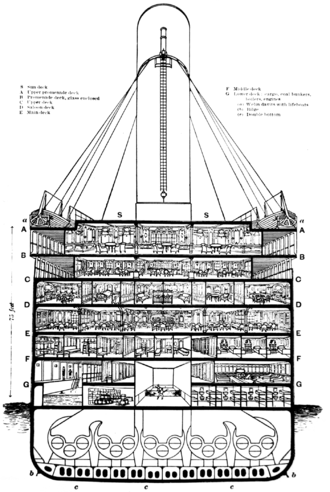

In [19]:
#creating function for creating categories based on the cabin of passengers
def cabin():
    global df_combined
    #replacing missing cabin values with U for unknown
    df_combined['Cabin'].fillna('U', inplace=True)

    df_combined['Cabin'] = df_combined['Cabin'].map(lambda ca: ca[0])
    #dummy encoding
    cabin_dummies = pd.get_dummies(df_combined['Cabin'], prefix='Cabin')
    df_combined = pd.concat([df_combined, cabin_dummies], axis=1)
    df_combined.drop('Cabin', inplace=True, axis=1)
    return df_combined

In [20]:
df_combined = cabin()
df_combined.head()

/tmp/ipython-input-19-2773511882.py:5: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,FamilySize,Singleton,SmallFamily,LargeFamily,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.0,2,0,1,0,False,False,True,False,False,False,False,False,False,False,False,True
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.0,2,0,1,0,True,False,False,False,False,True,False,False,False,False,False,False
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.0,1,1,0,0,False,False,True,False,False,False,False,False,False,False,False,True
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.0,2,0,1,0,False,False,True,False,False,True,False,False,False,False,False,False
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0,1,1,0,0,False,False,True,False,False,False,False,False,False,False,False,True


##**4. Creating categories based on the Age of passangers**
Now, we'll segregate passangers based on their age. Since the spread of age property is high and ranges from 0.4 to 80 years, we'll create smaller ranges of Age to categorize passangers. Here, we'he chosen 0(for less than 11), 1(12 to 18), 2(19 to 22), 3(23 to 27), 4(28 to 33), 5(34 to 46), 6(47 to 66), 7(67 and above).

In [21]:
#comverting age decimal values to integer
df_combined['Age'] = df_combined['Age'].astype(int)
#Converting the age range into categories
df_combined.loc[df_combined['Age'] <= 11, 'Age'] = 0
df_combined.loc[(df_combined['Age'] > 11) & (df_combined['Age'] <= 18), 'Age'] = 1
df_combined.loc[(df_combined['Age'] > 18) & (df_combined['Age'] <= 22), 'Age'] = 2
df_combined.loc[(df_combined['Age'] > 22) & (df_combined['Age'] <= 27), 'Age'] = 3
df_combined.loc[(df_combined['Age'] > 27) & (df_combined['Age'] <= 33), 'Age'] = 4
df_combined.loc[(df_combined['Age'] > 33) & (df_combined['Age'] <= 46), 'Age'] = 5
df_combined.loc[(df_combined['Age'] > 46) & (df_combined['Age'] <= 66), 'Age'] = 6
df_combined.loc[df_combined['Age'] >= 66, 'Age'] = 7
#distribution
df_combined['Age'].value_counts()

,count
Age,
4,442
5,216
3,170
2,138
6,138
1,105
0,91
7,9


##**5. Creating categories based on Fare of passangers**
Finally, now we'll tag passangers based on their economic status or the fare they paid for the journey. Again, since the spread of prices is very high and ranges from 0 to 512. So, again we'll segment passangers based on the fare in smaller bins of 0(less than 7), 1(8 to 14), 2(15 to 31), 3(32 to 99), 4(100 to 250), 5(251 and above).

In [22]:
#converting fare to interger values and then into categories
df_combined.loc[df_combined['Fare'] <= 7, 'Fare'] = 0
df_combined.loc[(df_combined['Fare'] > 7) & (df_combined['Fare'] <= 14), 'Fare'] = 1
df_combined.loc[(df_combined['Fare'] > 14) & (df_combined['Fare'] <= 31), 'Fare'] = 2
df_combined.loc[(df_combined['Fare'] > 31) & (df_combined['Fare'] <= 99), 'Fare'] = 3
df_combined.loc[(df_combined['Fare'] > 99) & (df_combined['Fare'] <= 250), 'Fare'] = 4
df_combined.loc[df_combined['Fare'] >= 250, 'Fare'] = 5
df_combined['Fare'] = df_combined['Fare'].astype(int)
#distribution
df_combined['Fare'].value_counts()

,count
Fare,
1,412
2,327
0,250
3,236
4,67
5,17


##**6. Creating categories based on the Title of the passangers**
Now, it is to categorize based on Title of passangers. This is not a straight-forward value which we can analyze mathmatically, as the title of a person wouldn't mean anything to the iceberg that hit Titanic or to the chilling water that drowned anyone it could. But we know that passangers registered with Mr, Mrs, Master and other royal names would probably be rich and would have been given preference while saving and transferring using life boats. So, we'll categorize them only into Mr, Mrs, Master, Miss and Rare(which contains all other royal and rare titles used by very few passangers).

In [23]:
###Get title from name
common_titles = ["Mr", "Mrs", "Miss", "Master"]
titles = []
for name in df_combined['Name']:
    title = name.split(',')[1].split('.')[0].strip()
    if title in common_titles:
        titles.append(title)
    elif title=="Mlle":
        titles.append("Miss")
    elif title=="Mme":
        titles.append("Mrs")
    else:
        titles.append("Rare")
df_titles = pd.DataFrame(titles, columns=['Titles'])
title_dummies = pd.get_dummies(df_titles['Titles'], prefix='Title')
title_dummies = title_dummies.reset_index(drop=True)
df_combined = df_combined.reset_index(drop=True)
df_combined = pd.concat([df_combined, title_dummies], axis=1)

In [24]:
df_combined.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,FamilySize,Singleton,SmallFamily,LargeFamily,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,1,3,"Braund, Mr. Owen Harris",male,2,1,0,A/5 21171,0,2,0,1,0,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,5,1,0,PC 17599,3,2,0,1,0,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False
2,3,3,"Heikkinen, Miss. Laina",female,3,0,0,STON/O2. 3101282,0,1,1,0,0,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,5,1,0,113803,3,2,0,1,0,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False
4,5,3,"Allen, Mr. William Henry",male,5,0,0,373450,1,1,1,0,0,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False


###Creating categories for Male and Female, and dropping few uneccessary columns

In [25]:
#dummies for gender
gender_dummies = pd.get_dummies(df_combined['Sex'])
df_combined = pd.concat([df_combined, gender_dummies], axis=1)
df_combined.drop('Sex', axis=1, inplace=True)

In [26]:
#dropping down Name and ticket columns, and passengerId cloumn
df_combined.drop(['PassengerId',"Name","Ticket"], axis=1, inplace=True)

In [27]:
df_combined.head()

,Pclass,Age,SibSp,Parch,Fare,FamilySize,Singleton,SmallFamily,LargeFamily,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,female,male
0,3,2,1,0,0,2,0,1,0,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True
1,1,5,1,0,3,2,0,1,0,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True,False
2,3,3,0,0,0,1,1,0,0,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False
3,1,5,1,0,3,2,0,1,0,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True,False
4,3,5,0,0,1,1,1,0,0,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True


# Building and Training the Model

In [28]:
#Separating the train and test dataframes
x_train = df_combined[:891].copy()
x_test = df_combined[891:].copy()
x_test.reset_index(inplace=True, drop=True)
x_train.shape, x_test.shape

((891, 28), (418, 28))

##**1. Random Forest Model**

In [29]:
random_forest = RandomForestClassifier()
random_forest.fit(x_train, y_train)

y_pred_random_forest = random_forest.predict(x_test)

random_forest_accuracy = round(random_forest.score(x_train, y_train)*100, 2)

##**2. Logistic Regression Model**

In [30]:
log_regres = LogisticRegression()
log_regres.fit(x_train, y_train)

y_pred_log_regres = log_regres.predict(x_test)

log_regres_accuracy = round(log_regres.score(x_train, y_train)*100, 2)

##**3. K-nearest Neighbors**

In [31]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)

y_pred_knn = knn.predict(x_test)

knn_accuracy = round(knn.score(x_train, y_train)*100, 2)

##**4. Gaussian Naive Bayes Model**

In [32]:
gaussian = GaussianNB()
gaussian.fit(x_train, y_train)

y_pred_gaussian = gaussian.predict(x_test)

gaussian_accuracy = round(gaussian.score(x_train, y_train)*100, 2)

##**5. Perceptrons Model**

In [33]:
perceptron = Perceptron()
perceptron.fit(x_train, y_train)

y_pred_perceptron = perceptron.predict(x_test)

perceptron_accuracy = round(perceptron.score(x_train, y_train)*100, 2)

##**6. Support Vector Machine Model**

In [34]:
svc = LinearSVC()
svc.fit(x_train, y_train)

y_pred_svc = svc.predict(x_test)

svc_accuracy = round(svc.score(x_train, y_train)*100, 2)

##**7. Decision Tree Model**

In [35]:
tree = DecisionTreeClassifier()
tree.fit(x_train, y_train)

y_pred_tree = tree.predict(x_train)

tree_accuracy = round(tree.score(x_train, y_train)*100, 2)

##**8. XGBoost Model**

In [36]:
#Transforming data into Dmatrix form
d_x_train = xgb.DMatrix(x_train, label=y_train)

In [37]:
#Setting the parameters
param = {
    'eta': 0.5,
    'max_depth': 16,
    'objective': 'multi:softprob',
    'num_class': 3}

steps = 20  # The number of training iterations

In [38]:
#Training the model
xgb_model = xgb.train(param, d_x_train, steps)

y_pred_xgb = xgb_model.predict(d_x_train)
#Converting the prediction intp numpy array
y_pred_xgb_new = np.asarray([np.argmax(line) for line in y_pred_xgb])

In [39]:
xgb_model_accuracy = round(accuracy_score(y_train, y_pred_xgb_new)*100, 2)

##**Which is the best model for prediction?**

In [40]:
best_model = pd.DataFrame({
    'Model': ['Random Forest','Logistic Regression','K-Nearest Neighbour','Gaussian Naive Bayes','Perceptron','SVM','Decision Tree','XGBoost'],
    'Result': [random_forest_accuracy,log_regres_accuracy,knn_accuracy,gaussian_accuracy,perceptron_accuracy,svc_accuracy,tree_accuracy,xgb_model_accuracy]})
best_model.sort_values(by=['Result'], ascending=False, inplace=True)
best_model.reset_index(inplace=True, drop=True)
fig = go.Figure(data=[go.Table(
    header=dict(values=list(best_model.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[best_model.Model, best_model.Result],
               fill_color='lavender',
               align='left'))
])
fig.show()

## K-Fold Cross Validation

In [41]:
rf = RandomForestClassifier()
scores = cross_val_score(rf, x_train, y_train, cv=10, scoring='accuracy')

print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.77777778 0.85393258 0.75280899 0.84269663 0.85393258 0.84269663
 0.83146067 0.80898876 0.84269663 0.83146067]
Mean: 0.823845193508115
Standard Deviation: 0.0322206235415777


## Feature Importance

In [42]:
importances = pd.DataFrame({'Feature':x_train.columns,'Importance':np.round(random_forest.feature_importances_,3)})
importances_df = importances.sort_values('Importance', ascending=False).reset_index(drop=True)
importances_plot = importances.sort_values('Importance', ascending=False).set_index('Feature')
importances_plot.head()

,Importance
Feature,
Age,0.135
Title_Mr,0.133
male,0.097
Fare,0.093
female,0.088


In [43]:
#Plotting the Features importances
fig_bar_feature = go.Figure()
fig_bar_feature.add_trace(go.Bar(x=importances_df['Feature'], y=importances_df['Importance']))
fig_bar_feature.update_layout(width=800, title_text='Bar chart representing Importances of Features',
                       xaxis_title_text='Features', yaxis_title_text='Importance', xaxis_tickangle=-45)
fig_bar_feature.show()

In [44]:
for i in range(23, importances_df.shape[0]):
    column = importances_df['Feature'][i]
    df_combined.drop([column], inplace=True, axis=1)

df_combined.head()

,Pclass,Age,SibSp,Parch,Fare,FamilySize,Singleton,SmallFamily,LargeFamily,Embarked_C,Embarked_S,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_U,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,female,male
0,3,2,1,0,0,2,0,1,0,False,True,False,False,False,False,True,False,False,True,False,False,False,True
1,1,5,1,0,3,2,0,1,0,True,False,False,True,False,False,False,False,False,False,True,False,True,False
2,3,3,0,0,0,1,1,0,0,False,True,False,False,False,False,True,False,True,False,False,False,True,False
3,1,5,1,0,3,2,0,1,0,False,True,False,True,False,False,False,False,False,False,True,False,True,False
4,3,5,0,0,1,1,1,0,0,False,True,False,False,False,False,True,False,False,True,False,False,False,True


## Training Random Forest Model Again

In [45]:
#Separate the train and test dataframes
x_train = df_combined[:891].copy()
x_test = df_combined[891:].copy()
x_test.reset_index(inplace=True, drop=True)

In [46]:
random_forest = RandomForestClassifier()
random_forest.fit(x_train, y_train)
y_prediction = random_forest.predict(x_test)

accuracy_random_forest = round(random_forest.score(x_train, y_train)*100, 2)
print("The accuracy after removing least important Features is {}, which is same as before removing.".format(accuracy_random_forest))

The accuracy after removing least important Features is 92.48, which is same as before removing.


## Training Decision Tree Model Again

In [47]:
tree = DecisionTreeClassifier()
tree.fit(x_train, y_train)

y_pred_tree = tree.predict(x_test)

tree_accuracy = round(tree.score(x_train, y_train)*100, 2)
print("The accuracy after removing least important Features is {}, which is same as before removing.".format(tree_accuracy))

The accuracy after removing least important Features is 92.48, which is same as before removing.


## Training XGBoost Model Again

In [48]:
#Transforming data into Dmatrix form
d_x_train = xgb.DMatrix(x_train, label=y_train)
d_x_test = xgb.DMatrix(x_test)

In [49]:
xgb_model = xgb.train(param, d_x_train, steps)
y_pred_xgb = xgb_model.predict(d_x_test)
y_pred_xgb_new = np.asarray([np.argmax(line) for line in y_pred_xgb])

# Submission

In [ ]:
# output = pd.DataFrame({'PassengerID': test_data.PassengerId,'Survived':y_pred_xgb_new})
# output.to_csv("my_submission.csv", index=False)
# print("Submission successfully saved!!!")